In [1]:
# autoreload libraries
%load_ext autoreload
%autoreload 2

import pandas as pd

import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import numpy as np
import folium
from folium.map import Element
import seaborn as sns
from IPython.display import Markdown as md
from IPython.display import display, HTML

import xyzservices.providers as xyz

from nycschools import schools, geo, ui, snapshot as snap

import warnings
warnings.filterwarnings('ignore')

In [2]:
# load all of the data and clean it up
loc = geo.load_school_locations()
districts = geo.load_districts()
df = schools.load_school_demographics()
feet = geo.load_school_footprints()


In [3]:
import nycschools
snapshots = snap.load_snapshots()
snapshots.head()


,dbn,ay,abbr_school_type,address,attendance_rate,authorizer_website,co_located,dates_of_review,district,dual_lang,...,teacher_3yr_exp_pct,teacher_amerindian_pct,teacher_asian_pct,teacher_black_pct,teacher_hispanic_pct,teacher_pacific_pct,teacher_white_pct,url,x_coordinate,y_coordinate
0,75K753,2019,D75,510 Clermont Avenue,98%,NaN,NaN,December 2017,75,NaN,...,69%,0%,N/A (fewer than 5 teachers),45%,16%,0%,28%,https://tools.nycenet.edu/api/v1/data/school/a...,992779.0,187959.0
1,75X352,2019,D75,1000 East Tremont Avenue,97%,NaN,NaN,December 2017,75,NaN,...,74%,0%,4%,25%,28%,0%,37%,https://tools.nycenet.edu/api/v1/data/school/a...,1016753.0,245496.0
2,75X469,2019,D75,3177 Webster Avenue,97%,NaN,NaN,December 2017,75,NaN,...,60%,0%,6%,12%,39%,0%,40%,https://tools.nycenet.edu/api/v1/data/school/a...,1018564.0,257153.0
3,75X596,2019,D75,850 Baychester Avenue,97%,NaN,NaN,January 2020,75,NaN,...,77%,0%,N/A (fewer than 5 teachers),12%,15%,0%,70%,https://tools.nycenet.edu/api/v1/data/school/a...,1030803.0,257757.0
4,75X721,2019,D75,2697 Westchester Avenue,97%,NaN,NaN,January 2019,75,NaN,...,77%,0%,6%,11%,23%,0%,57%,https://tools.nycenet.edu/api/v1/data/school/a...,1028765.0,246346.0


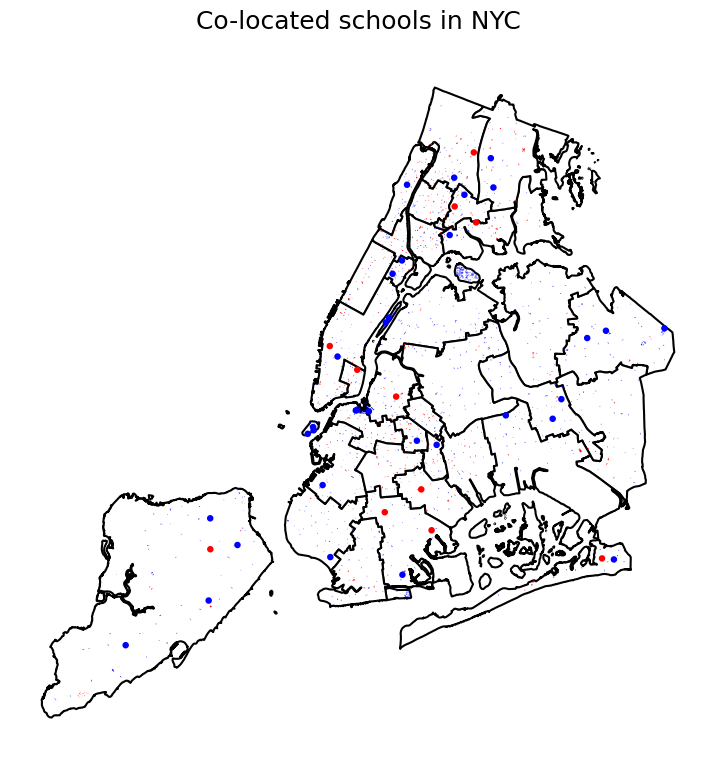

In [69]:
loc["point"] = loc.x.astype(str) +"," +loc.y.astype(str)
coloc = loc[["dbn", "point"]].groupby("point").count().reset_index()
coloc["colocated"] = coloc["dbn"] > 1
coloc.columns = ["point", "school_n", "colocated"]
data = loc.merge(coloc, on="point", how="inner")
data = feet.merge(data[["bbl","school_n", "colocated"]], on="bbl", how="inner")
data = data[['bbl', 'colocated', 'geometry', 'school_n']].drop_duplicates()
data["color"] = data["colocated"].apply(lambda x: "red" if x else "blue")


# configure the look of our map
fig, ax = plt.subplots(figsize=(18, 9))
fig.patch.set_facecolor('white')
sns.set_context('talk')
plt.axis('off')

ax.set_title( "Co-located schools in NYC", color="black", pad=20)

ax = districts.plot(ax=ax, color="white", edgecolor="black")
data.plot(ax=ax, column="colocated", color=data.color, markersize=10)
plt.show()



Public Schools in NYC
====================
Our data, current to 2022 shows 2,119 public schools in NYC.


,School Type,Number of Schools
1,Community Schools,"25,373"
0,Charter Schools,"2,306"
2,District 75 (SWD),604
3,Transfer Schools,61
0,Total,"28,344"


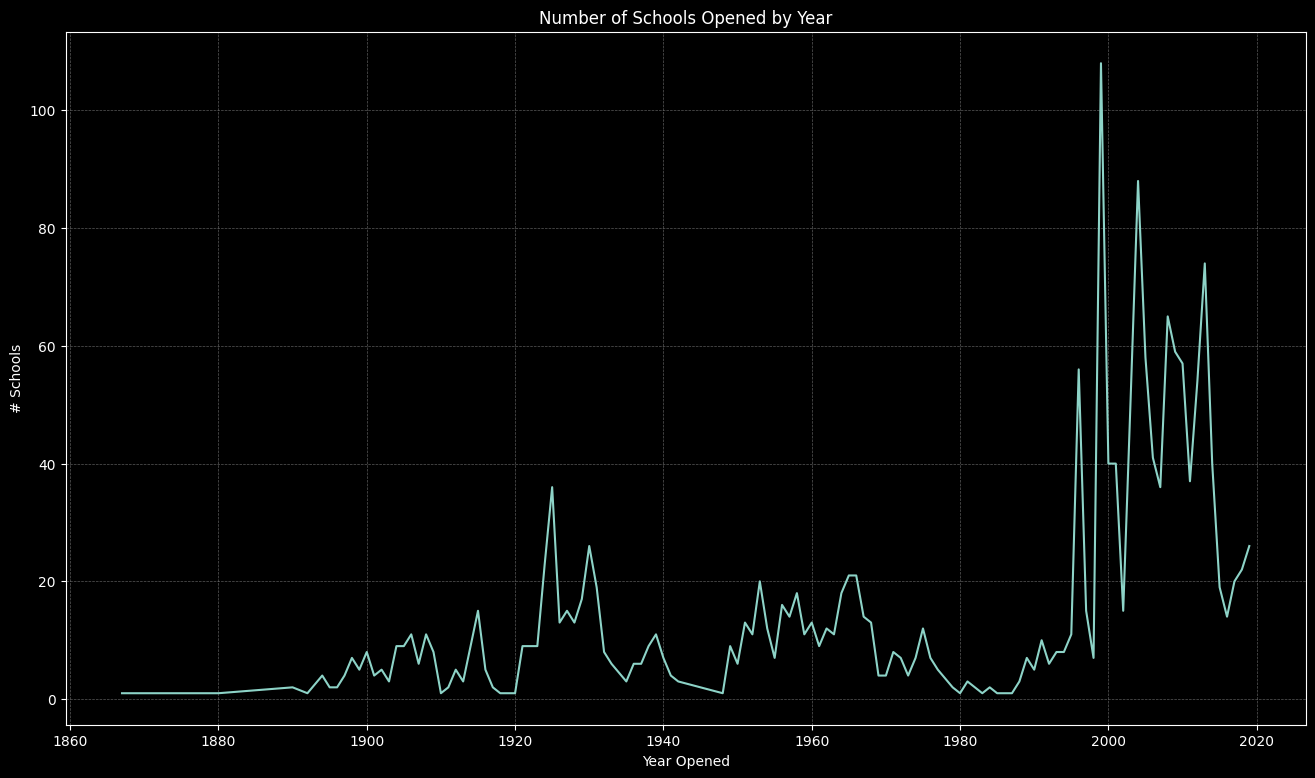


Charter Schools
---------------
The first charter schools opened in NYC in 1999,
with 258 charters opening.


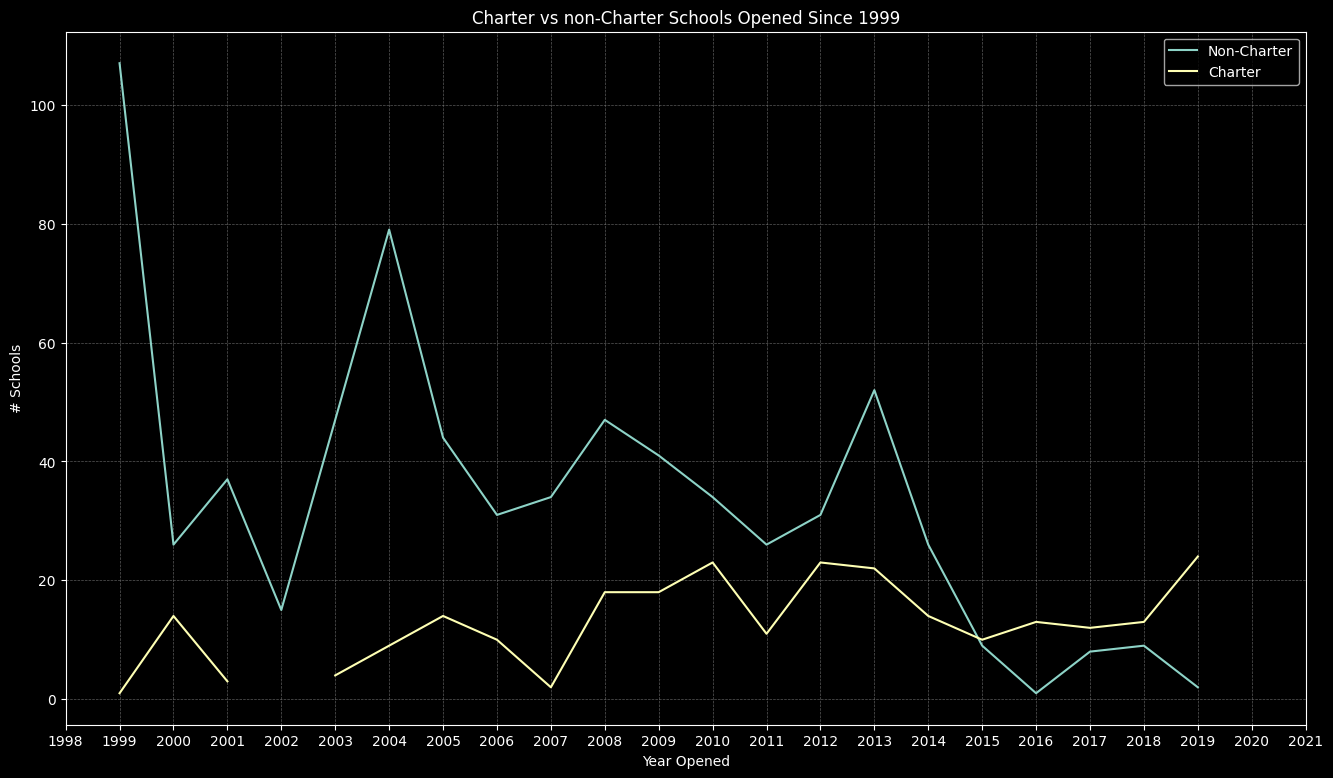

In [3]:
def school_type(district):
    if district == 84:
        return "Charter Schools"
    elif district == 79:
        return "Transfer Schools"
    elif district == 75:
        return "District 75 (SWD)"
    
    return "Community Schools"

df["school_type"] = df.district.apply(school_type)
school_counts = pd.DataFrame(df.groupby("school_type").dbn.count()).reset_index()
school_counts.sort_values("dbn", ascending=False, inplace=True)
school_counts.columns = ["School Type", "Number of Schools"]
school_counts = pd.concat([school_counts, pd.DataFrame(["Total", school_counts["Number of Schools"].sum()], index=["School Type", "Number of Schools"]).T])
school_counts = ui.fmt_table(school_counts,num_cols=["Number of Schools"])



open_year = loc.copy()
open_year["charter"] = open_year.district == 84

plt.style.use("dark_background")
ax = open_year[open_year.open_year > 0].groupby(["open_year"]).dbn.count().plot(figsize=(16,9))
ax.set_title("Number of Schools Opened by Year")
ax.set_ylabel("# Schools")
ax.set_xlabel("Year Opened")
ax.grid(True, color='gray', linestyle='--', linewidth=0.5, alpha=0.7)


ui.show_md(f"""
Public Schools in NYC
====================
Our data, current to 2022 shows {df.dbn.nunique():,} public schools in NYC.
""")


display(school_counts)
plt.show()

ui.show_md(f"""
Charter Schools
---------------
The first charter schools opened in NYC in {open_year[open_year.charter].open_year.min()},
with {open_year[open_year.charter].dbn.nunique():,} charters opening.
""")

ax = open_year[open_year.open_year > 1998].groupby(["open_year", "charter"]).dbn.count().unstack().plot(figsize=(16,9))
ax.set_title("Charter vs non-Charter Schools Opened Since 1999")
ax.set_ylabel("# Schools")
ax.set_xlabel("Year Opened")
ax.grid(True, color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
years = np.arange(1998, 2022)
ax.set_xticks(years)
ax.set_xticklabels(years)
ax.legend(["Non-Charter", "Charter"])
plt.show()

In [6]:
# merge school locations and demographics
# get only the demo columns that aren't in locations already
cols = ["dbn"] + list(set(df.columns) - set(loc.columns))
data = loc.merge(df[df.ay == df.ay.max()][cols], on="dbn", how="inner")

# find the middle of all of the school points
centroids = data.geometry.centroid
lat = centroids.y.mean()
lon = centroids.x.mean()
m = folium.Map(location=[lat, lon], zoom_start=12, tiles=xyz.CartoDB.PositronNoLabels.build_url(), attr="cartodb")

# make a layer for each decade
data['layer'] = data.open_year // 10 * 10

decades = sorted(data['layer'].unique(), reverse=True)
colors = sns.color_palette("tab20", len(decades)).as_hex()
display(colors)
colors = ['#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c', '#98df8a', '#d62728', '#ff9896',
          '#9467bd', '#c5b0d5', '#8c564b', '#c49c94', '#e377c2', '#f7b6d2', '#7f7f7f', '#ff00ff', '#c7c7c7']
legend = dict(zip(decades, colors))
data["color"] = data['layer'].map(legend)
data["title"] = data.apply(lambda x: f"{x.school_name} ({x.open_year})", axis=1)

legend = [(f"{y}-{y+9} ({ len(data[data.layer == y]) } schools)", c, y) for y,c in legend.items()]
legend[-1] = (f"Unknown ({ len(data[data.layer == 0]) } schools)", legend[-1][1], 0)
m = ui.map_layers(m, data)
m = ui.map_legend(m, legend, title="School Openings 1860-2020")
m.add_child(folium.LayerControl())
m.save("colac.html")
m

['#1f77b4',
 '#aec7e8',
 '#ff7f0e',
 '#ffbb78',
 '#2ca02c',
 '#98df8a',
 '#d62728',
 '#ff9896',
 '#9467bd',
 '#c5b0d5',
 '#8c564b',
 '#c49c94',
 '#e377c2',
 '#f7b6d2',
 '#7f7f7f',
 '#c7c7c7',
 '#bcbd22']